In [1]:
import copy
import pandas as pd
import re
import itertools
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Perceptron, SGDRegressor
from sklearn import svm, tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, quantile_transform
from sklearn.compose import TransformedTargetRegressor
import math
from numpy import cov

np.random.seed(42) # fix randomness in Scikit-learn

## 1. Read data

In [44]:
df_BioPlex = pd.read_csv('../BioPlex_293T_Network_10K_Dec_2019.tsv', sep='\t')
df_CETSA = pd.read_csv('../S21.csv')
# pInt indicates interactions

## 2. Merge tables

In [7]:
df_int = df_BioPlex.merge(df_CETSA, left_on='SymbolA', right_on='GeneName')
df_int_2 = df_int.merge(df_CETSA, left_on='SymbolB', right_on='GeneName')
df_int_2_filtered = df_int_2

## 3. Select features

In [45]:
X_columns = ['T37_x', 'T40_x', 'T43_x', 'T46_x', 'T49_x', 'T52_x', 'T55_x', 'T58_x', 'T61_x','T64_x', 'T37_y', 'T40_y', 'T43_y', 'T46_y', 'T49_y', 
             'T52_y','T55_y','T58_y','T61_y','T64_y']
Y_columns = ['pInt']
X = df_int_2_filtered[X_columns].to_numpy()
Y = df_int_2_filtered[Y_columns].to_numpy()
print(X.shape[0], 'number of samples')

41490 number of samples


## 4. Fit models and cross validation
#### Using Decision Tree

In [47]:
y_preds = []
def validate_one_fold(test_start, test_end):
    X_test = X[test_start:test_end,:]
    X_ = np.delete(X, slice(test_start,test_end), 0)
    y_test = Y[test_start:test_end,:]
    y_ = np.delete(Y, slice(test_start,test_end), 0)

    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(X_, y_)
    mae = mean_absolute_error(y_test, clf.predict(X_test))
#     print(clf.score(X_, y_), mae)
    y_pred = clf.predict(X_test)
    return y_pred, mae

starts = [int(i*X.shape[0]/5) for i in range(5)]
ends = [s for s in starts[1:]]
ends.append(X.shape[0]+1)
# print(starts, ends)
maes = []
for s, e in zip(starts, ends):
    y_pred, mae = validate_one_fold(s, e)
    y_preds.extend(y_pred)
    maes.append(mae)
print(sum(maes)/len(maes), 'MAE')

0.06980480536939768 MAE


In [49]:
df_int_2_filtered['Prediction'] = y_preds
df_slice = df_int_2_filtered[['SymbolA', 'SymbolB', 'pInt', 'GeneName_x', 'GeneName_y', 'Prediction']]
df_slice['Error'] = abs(df_slice['pInt'] - df_slice['Prediction'])
df_slice_sorted = df_slice.sort_values('Error')

/home/peisheng/crp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 5. Plot individual pairs

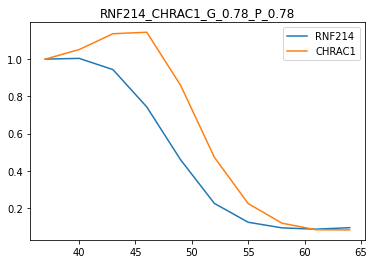

In [50]:
count = 0
lower_thresh = 0.75
upper_thresh = 0.8
for row in df_slice_sorted.head(10000).itertuples():
    if row.pInt >= lower_thresh and row.pInt <= upper_thresh:
        count += 1
        full_row = df_int_2_filtered.loc[[row.Index]]
        x_feature = full_row[['T37_x', 'T40_x', 'T43_x', 'T46_x', 'T49_x', 'T52_x', 'T55_x', 'T58_x', 'T61_x', 'T64_x']].to_numpy()
        y_feature = full_row[['T37_y', 'T40_y', 'T43_y', 'T46_y', 'T49_y', 'T52_y', 'T55_y', 'T58_y', 'T61_y', 'T64_y']].to_numpy()
        new_df = pd.DataFrame(data={str(row.GeneName_x):x_feature[0], str(row.GeneName_y):y_feature[0]}, index = [37, 40, 43, 46, 49, 52, 55, 58, 61, 64])
        new_df.plot()
        file_name = str(row.GeneName_x)+'_'+str(row.GeneName_y)+'_G_'+str(f'{row.pInt:.2f}')+'_P_'+str(f'{row.Prediction:.2f}')
        plt.title(file_name)
#         plt.savefig('HEK293T_figures/'+ file_name + '.png')
    if count > 0:
        break

## 6. Plot error distribution

Text(0.5, 1.0, 'Distribution of Error')

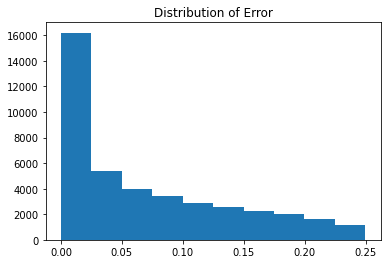

In [53]:
plt.hist(df_slice['Error'])
plt.title('Distribution of Error')
# plt.savefig('Error.png', dpi=200)

## 7. Plot y groundtruth distribution

Text(0.5, 1.0, 'Distribution of Y groundtruth')

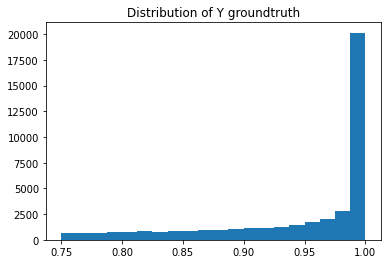

In [62]:
plt.hist(Y, bins=20)
plt.title('Distribution of Y groundtruth')

## 8. Plot y prediction distribution

Text(0.5, 1.0, 'Distribution of Y prediction')

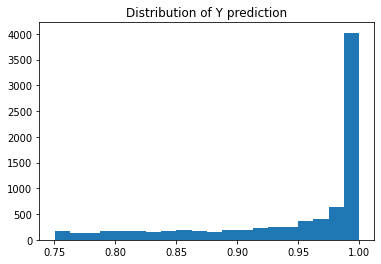

In [64]:
plt.hist(y_pred, bins=20)
plt.title('Distribution of Y prediction')
# plt.savefig('Test_Y.png', dpi=200)

## 9. Gradient Boosting

In [ ]:
# regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=0, loss='ls')
# regr.fit(X, y.ravel())
# mae = mean_absolute_error(y_test, regr.predict(X_test))
# print(regr.score(X, y), mae)
# y_pred = regr.predict(X_test)
# plt.hist(y_pred, bins=20)
# plt.title('GB_pred')